# Hebrew Idiom Processing Project - Google Colab

**Detection Task**: Tag sentences correctly if a phrase is an idiom

## Models:
- mBERT (bert-base-multilingual-cased)
- XLM-RoBERTa (xlm-roberta-base)
- mT5 (google/mt5-small)

## Fine-tuning Conditions:
- English Only: ID10M (English) + EPIE + Idiomem_corrected
- All Languages: ID10M + EPIE + Idiomem_corrected
- Hebrew: Hebrew datasets only

In [ ]:
# Install required packages
!pip install transformers datasets scikit-learn matplotlib seaborn pandas numpy tqdm gdown
!pip install accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
import torch
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, AutoModelForMaskedLM,
    MT5ForConditionalGeneration, TrainingArguments, Trainer,
    DataCollatorForTokenClassification, DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq
)
from datasets import Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime
from tqdm import tqdm

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [ ]:
# Configuration
MODEL_CONFIGS = {
    "mbert": "distilbert-base-multilingual-cased",
    "xlm_roberta": "xlm-roberta-base",
    "mt5": "google/mt5-small",
}

# Training configurations
TRAINING_CONFIGS = {
    "fast": {"batch_size": 8, "epochs": 1, "eval_steps": 1000},
    "standard": {"batch_size": 16, "epochs": 3, "eval_steps": 1000},
}

# Languages
ID10M_LANGUAGES = ["chinese", "dutch", "english", "french", "german",
                  "italian", "japanese", "polish", "portuguese", "spanish"]

# Fine-tuning conditions
CONDITIONS = {
    "english_only": ["english", "english_idioms"],
    "all_languages": ID10M_LANGUAGES + ["english_idioms"],
    "hebrew": ["hebrew_idioms"],
    "mixed": ["english", "english_idioms", "hebrew_idioms"]
}

# BIO tags
TAG_LIST = ["O", "B-IDIOM", "I-IDIOM"]
ID2TAG = {i: tag for i, tag in enumerate(TAG_LIST)}
TAG2ID = {tag: i for i, tag in enumerate(TAG_LIST)}
NUM_TAGS = len(TAG_LIST)

Configuration loaded successfully!


In [ ]:
# Download datasets
print("Downloading datasets...")

# Download ID10M, EPIE, and Idiomem datasets
!rm -rf id10m epie idiomem
!git clone https://github.com/Babelscape/ID10M.git id10m
!git clone https://github.com/prateeksaxena2809/EPIE_Corpus.git epie
!git clone https://github.com/omerday/nlp-idiom-he.git idiomem

# Download Hebrew datasets using gdown
!pip install -U gdown
import gdown

# Create data directory
data_dir = "/content/datasets"
os.makedirs(data_dir, exist_ok=True)

# Download Hebrew datasets (replace with your actual folder ID)
folder_id = "1QLZug25rY7-UcrPyrw5bExcZJFpejP3U"
gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}",
                   output=data_dir, quiet=False)


Cloning into 'id10m'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 68 (delta 9), reused 54 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 18.31 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Cloning into 'epie'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 42 (delta 12), reused 21 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 1.73 MiB | 4.74 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Cloning into 'idiomem'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 20 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 54.64 KiB | 917.00 KiB/s, done.
Resolving deltas: 100% (8/8), done.


Retrieving folder contents


Processing file 1p2qmqPbS8HL0Bt7-e5ZeBDE8L3Ci7Fmv heb_idioms_final.txt
Processing file 1-4sB9i-Jht-gVJWVRUG5XidF8CV6jpnM heb_idioms_meanings_final.txt


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1p2qmqPbS8HL0Bt7-e5ZeBDE8L3Ci7Fmv
To: /content/datasets/heb_idioms_final.txt
100%|██████████| 42.8k/42.8k [00:00<00:00, 37.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-4sB9i-Jht-gVJWVRUG5XidF8CV6jpnM
To: /content/datasets/heb_idioms_meanings_final.txt
100%|██████████| 16.8k/16.8k [00:00<00:00, 22.8MB/s]

Datasets downloaded successfully!



Download completed


In [ ]:
def parse_id10m(language: str) -> tuple[list, list]:
    """Parse ID10M dataset for a specific language with improved sentence handling"""
    words = []
    tags = []
    print(f'Parsing ID10M {language} corpus...')
    path = f'id10m/resources/bio_format/{language.lower()}/train_{language.lower()}.tsv'

    with open(path, 'r', encoding='utf-8') as file:
        words_in_sentence = []
        tags_in_sentence = []
        for line in file:
            line = line.replace('\n', '')
            if len(line.split('\t')) == 2:
                word, tag = line.split('\t')
                words_in_sentence.append(word.strip())
                tags_in_sentence.append(tag)
            else:
                # append the sentence list and the tags to the bigger list
                if words_in_sentence:
                    words.append(words_in_sentence)
                    tags.append(tags_in_sentence)
                words_in_sentence = []
                tags_in_sentence = []
        # Finally, check if the lists aren't empty and append them
        if words_in_sentence:
            words.append(words_in_sentence)
            tags.append(tags_in_sentence)
    print("Done.")
    if words:
        print(f"Sentence arrays: {len(words)}, Tag arrays: {len(tags)}")
        print(f"Average sentence length: {sum([len(sentence) for sentence in words]) / len(words):.2f}")
    else:
        print(f"No data found for {language}")

    return words, tags

def parse_epie_data() -> tuple[list, list]:
    """Parse EPIE dataset"""
    words, tags = [], []
    for type_name in ['Formal', 'Static']:

        word_path = f'epie/{type_name}_Idioms_Corpus/{type_name}_Idioms_Words.txt'
        tag_path = f'epie/{type_name}_Idioms_Corpus/{type_name}_Idioms_Tags.txt'

        with open(word_path, 'r', encoding='utf-8') as word_file, \
              open(tag_path, 'r', encoding='utf-8') as tag_file:
            while True:
                word_line = word_file.readline().strip()
                tag_line = tag_file.readline().strip()
                if not word_line or not tag_line:
                    break
                words_split = word_line.split()
                tags_split = tag_line.split()
                if len(words_split) == len(tags_split):
                    words.append(words_split)
                    tags.append(tags_split)

    return words, tags

def parse_idiomem_data() -> tuple[list, list]:
    """Parse Idiomem dataset with improved handling"""
    words, tags = [], []
    print("Parsing Idiomem Corpus...")
    try:
        with open('idiomem/idiomem-corrected.txt', 'r', encoding='utf-8') as file:
            # In Idiomem, first line is the idiom, second is the sentence and third is tags.
            while file.readline():  # We get rid of the first line of the triplet in the while
                sentence_line = file.readline().replace('\n', '')
                tags_line = file.readline().replace('\n', '')
                if sentence_line and tags_line:
                    sentence_words = sentence_line.split(' ')
                    sentence_tags = tags_line.split(' ')
                    if len(sentence_words) == len(sentence_tags):
                        words.append(sentence_words)
                        tags.append(sentence_tags)
        print('Done.')
        if words:
            print(f"Sentence arrays: {len(words)}, Tag arrays: {len(tags)}")
            print(f"Average sentence length: {sum([len(sentence) for sentence in words]) / len(words):.2f}")
    except FileNotFoundError:
        print("Warning: Idiomem file not found")
    return words, tags

def parse_hebrew_dataset() -> tuple[list, list]:
    """Parse Hebrew dataset"""
    words, tags = [], []

    with open('/content/datasets/heb_idioms_final.txt', 'r', encoding='utf-8') as file:
        lines = file.readlines()

    i = 0
    while i < len(lines) - 2:
        sentence = lines[i + 1].strip()
        tag_line = lines[i + 2].strip()
        if sentence and tag_line:
            sentence_words = sentence.split()
            sentence_tags = tag_line.split()
            if len(sentence_words) == len(sentence_tags):
                words.append(sentence_words)
                tags.append(sentence_tags)
        i += 3

    if words:
        print(f"Hebrew sentences: {len(words)}")
        print(f"Average sentence length: {sum([len(sentence) for sentence in words]) / len(words):.2f}")

    return words, tags

Improved data loading functions defined!


In [ ]:
def tokenize_and_align_labels(tokenizer, dataset):
    """
    Tokenizes input text and, for some tasks, aligns labels to tokens.
    Supports: detection (token classification).
    Returns tokenizer outputs with optional label IDs for model training.
    """
    if isinstance(dataset["words"][0], list):
        tokenized_inputs = tokenizer.batch_encode_plus(
            dataset["words"],
            is_split_into_words=True,
            truncation=True,
            padding=True,
            return_tensors="pt"
        )

        aligned_tags = []
        max_len = tokenized_inputs['input_ids'].shape[1]

        for i, sentence_words in enumerate(dataset["words"]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            sentence_tags = []

            for word_idx in word_ids:
                if word_idx is None:
                    sentence_tags.append(-100)
                elif word_idx != previous_word_idx:
                    tag = dataset["tags"][i][word_idx]
                    sentence_tags.append(TAG2ID[tag])
                else:
                    sentence_tags.append(-100)
                previous_word_idx = word_idx

            padded_tags = sentence_tags + [-100] * (max_len - len(sentence_tags))
            aligned_tags.append(padded_tags)

        tokenized_inputs["labels"] = aligned_tags
        return tokenized_inputs


def prepare_dataset_for_training(tokenized_data, language_list):
    """
    Merges tokenized data from multiple languages into one Hugging Face Dataset.
    Handles both tensor and list formats, converting everything to lists.
    Returns a Dataset with input_ids, attention_mask, and optional labels for training.
    """
    combined_data = {'input_ids': [], 'attention_mask': [], 'labels': []}

    for language in language_list:
        if language in tokenized_data:
            if isinstance(tokenized_data[language]['input_ids'], torch.Tensor):
                combined_data['input_ids'].extend(tokenized_data[language]['input_ids'].tolist())
                combined_data['attention_mask'].extend(tokenized_data[language]['attention_mask'].tolist())
                if 'labels' in tokenized_data[language]:
                    if isinstance(tokenized_data[language]['labels'], torch.Tensor):
                        combined_data['labels'].extend(tokenized_data[language]['labels'].tolist())
                    else:
                        combined_data['labels'].extend(tokenized_data[language]['labels'])
            else:
                combined_data['input_ids'].extend(tokenized_data[language]['input_ids'])
                combined_data['attention_mask'].extend(tokenized_data[language]['attention_mask'])
                if 'labels' in tokenized_data[language]:
                    combined_data['labels'].extend(tokenized_data[language]['labels'])

    return Dataset.from_dict(combined_data)

Updated tokenization functions for sentence-level data structure!


In [ ]:
# Load all datasets with processing
print("Loading datasets...")

datasets = {}

print("\nLoading ID10M datasets...")
for language in ID10M_LANGUAGES:
    words, tags = parse_id10m(language)
    if words:
        datasets[language] = {'words': words, 'tags': tags}
        print(f"  {language}: {len(words)} sentences")

print("\nLoading EPIE dataset...")
epie_words, epie_tags = parse_epie_data()
if epie_words:
    datasets['english_idioms'] = {'words': epie_words, 'tags': epie_tags}
    print(f"  EPIE: {len(epie_words)} sentences")

print("\nLoading Idiomem dataset...")
idiomem_words, idiomem_tags = parse_idiomem_data()
if idiomem_words:
    datasets['idiomem'] = {'words': idiomem_words, 'tags': idiomem_tags}
    print(f"  Idiomem: {len(idiomem_words)} sentences")

print("\nLoading Hebrew datasets...")
heb_words, heb_tags = parse_hebrew_dataset()
if heb_words:
    datasets['hebrew_idioms'] = {'words': heb_words, 'tags': heb_tags}
    print(f"  Hebrew idioms: {len(heb_words)} sentences")


Loading datasets...

Loading ID10M datasets...
Parsing ID10M chinese corpus...
Done.
Sentence arrays: 8249, Tag arrays: 8249
Average sentence length: 26.74
  chinese: 8249 sentences
Parsing ID10M dutch corpus...
Done.
Sentence arrays: 18801, Tag arrays: 18801
Average sentence length: 26.25
  dutch: 18801 sentences
Parsing ID10M english corpus...
Done.
Sentence arrays: 33757, Tag arrays: 33757
Average sentence length: 31.82
  english: 33757 sentences
Parsing ID10M french corpus...
Done.
Sentence arrays: 31807, Tag arrays: 31807
Average sentence length: 26.63
  french: 31807 sentences
Parsing ID10M german corpus...
Done.
Sentence arrays: 24126, Tag arrays: 24126
Average sentence length: 26.96
  german: 24126 sentences
Parsing ID10M italian corpus...
Done.
Sentence arrays: 26372, Tag arrays: 26372
Average sentence length: 27.80
  italian: 26372 sentences
Parsing ID10M japanese corpus...
Done.
Sentence arrays: 5741, Tag arrays: 5741
Average sentence length: 33.00
  japanese: 5741 sentences

Data Overview
          Language  Sentences  Total Words  Idiom Tags Idiom Percentage
0          chinese       8249       220560        8169            3.70%
1            dutch      18801       493467       13534            2.74%
2          english      33757      1074173       27621            2.57%
3           french      31807       847091       35144            4.15%
4           german      24126       650535       17802            2.74%
5          italian      26372       733137       19051            2.60%
6         japanese       5741       189443        3767            1.99%
7           polish      31963       778582       24654            3.17%
8       portuguese      27594       688667       13371            1.94%
9          spanish      25070       577405       21922            3.80%
10  english_idioms      25027       728224       73779           10.13%
11         idiomem        358         3712        1108           29.85%
12   hebrew_idioms        230         2785        

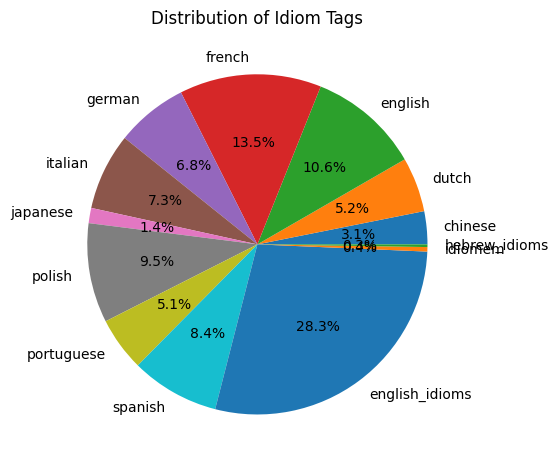

In [ ]:
print("=" * 60)
print("Data Overview")
print("=" * 60)

summary_data = []
for lang, data in datasets.items():
    words = data['words']
    tags = data['tags']

    idiom_count = 0
    total_words = 0
    for sentence_tags in tags:
        for tag in sentence_tags:
            total_words += 1
            if tag.startswith('B-IDIOM') or tag.startswith('I-IDIOM'):
                idiom_count += 1

    summary_data.append({
        'Language': lang,
        'Sentences': len(words),
        'Total Words': total_words,
        'Idiom Tags': idiom_count,
        'Idiom Percentage': f"{idiom_count/total_words*100:.2f}%" if total_words > 0 else "0%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Plot dataset sizes
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 3)
idiom_counts = [row['Idiom Tags'] for _, row in summary_df.iterrows()]
plt.pie(idiom_counts, labels=summary_df['Language'], autopct='%1.1f%%')
plt.title('Distribution of Idiom Tags')

plt.tight_layout()
plt.show()

In [ ]:
# Split datasets into training and validation
print("Splitting datasets...")

training_datasets = {}
validation_datasets = {}

for language, dataset in datasets.items():
    if len(dataset['words']) > 0:
        train_words, val_words, train_tags, val_tags = train_test_split(
            dataset['words'], dataset['tags'],
            test_size=0.2, random_state=42
        )

        training_datasets[language] = {
            'words': train_words, 'tags': train_tags
        }
        validation_datasets[language] = {
            'words': val_words, 'tags': val_tags
        }

print(f"Split {len(training_datasets)} datasets into training and validation")

Splitting datasets...
Split 13 datasets into training and validation


#Detection Task

Tag sentences correctly to identify if a phrase is an idiom using token classification.

In [ ]:
def compute_detection_metrics(eval_pred):
    """Compute metrics for detection task with confusion matrix"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for prediction, label in zip(predictions, labels):
        for pred_id, label_id in zip(prediction, label):
            if label_id != -100:
                true_predictions.append(pred_id)
                true_labels.append(label_id)

    # Basic metrics
    accuracy = accuracy_score(true_labels, true_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, true_predictions, average='weighted', zero_division=0
    )

    # Confusion matrix
    cm = confusion_matrix(true_labels, true_predictions, labels=range(NUM_TAGS))
    cm_list = cm.tolist()

    # Idiom-specific metrics (binary classification)
    idiom_predictions = [1 if pred > 0 else 0 for pred in true_predictions]
    idiom_labels = [1 if label > 0 else 0 for label in true_labels]

    idiom_precision, idiom_recall, idiom_f1, _ = precision_recall_fscore_support(
        idiom_labels, idiom_predictions, average='binary', pos_label=1, zero_division=0
    )

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'idiom_f1': idiom_f1,
        'idiom_precision': idiom_precision,
        'idiom_recall': idiom_recall,
        'confusion_matrix': cm_list,
        'true_predictions': true_predictions,
        'true_labels': true_labels
    }

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=TAG_LIST, yticklabels=TAG_LIST)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def detection_report(trainer, tokenized_dataset, raw_dataset, language, k=5):
    print("\n" + "="*60)
    print(f"RESULT SUMMARY — {language.upper()}")
    print("="*60)

    preds = trainer.predict(tokenized_dataset)
    logits = preds.predictions              # (batch, seq_len, num_labels)
    label_ids = preds.label_ids             # (batch, seq_len)
    pred_ids_all = np.argmax(logits, axis=-1)

    true_preds_flat, true_labels_flat = [], []
    examples_ok, examples_err = [], []

    for i in range(len(raw_dataset["words"])):
      words = raw_dataset["words"][i]
      gold_tags_str = raw_dataset["tags"][i]
      gold_ids_full = [TAG2ID[t] for t in gold_tags_str]

      mask = (label_ids[i] != -100)
      pred_ids = pred_ids_all[i][mask].tolist()

      if len(pred_ids) < len(gold_ids_full):
          pred_ids.extend([0] * (len(gold_ids_full) - len(pred_ids)))
      elif len(pred_ids) > len(gold_ids_full):
          pred_ids = pred_ids[:len(gold_ids_full)]

      pred_tags = [ID2TAG[x] for x in pred_ids]
      gold_tags = gold_tags_str

      true_preds_flat.extend(pred_ids)
      true_labels_flat.extend(gold_ids_full)

      if pred_tags == gold_tags:
          if len(examples_ok) < k:
              examples_ok.append((" ".join(words), gold_tags, pred_tags))
      else:
          if len(examples_err) < k:
              examples_err.append((" ".join(words), gold_tags, pred_tags))

    acc = accuracy_score(true_labels_flat, true_preds_flat)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        true_labels_flat, true_preds_flat, average='weighted', zero_division=0
    )

    bin_true = [1 if y > 0 else 0 for y in true_labels_flat]
    bin_pred = [1 if y > 0 else 0 for y in true_preds_flat]

    idiom_prec, idiom_rec, idiom_f1, _ = precision_recall_fscore_support(
        bin_true, bin_pred, average='binary', pos_label=1, zero_division=0
    )

    tp = sum(1 for t, p in zip(bin_true, bin_pred) if t == 1 and p == 1)
    fp = sum(1 for t, p in zip(bin_true, bin_pred) if t == 0 and p == 1)
    fn = sum(1 for t, p in zip(bin_true, bin_pred) if t == 1 and p == 0)

    print(f"\nOverall:")
    print(f"  Accuracy: {acc:.3f} | F1 (weighted): {f1_w:.3f} | Precision: {prec_w:.3f} | Recall: {rec_w:.3f}")

    print(f"\nIdiom Detection (binary ‘any tag > 0’):")
    print(f"  Precision: {idiom_prec:.3f} | Recall: {idiom_rec:.3f} | F1: {idiom_f1:.3f}")
    print(f"  TP={tp}  FP={fp}  FN={fn}")

    if examples_ok:
        print(f"\n Correct examples (up to {k}):")
        for i, (sent, gold, pred) in enumerate(examples_ok, 1):
            print(f"  {i}. {sent}")
            print(f"     True: {gold}")
            print(f"     Pred: {pred}")

    if examples_err:
        print(f"\n Incorrect examples (up to {k}):")
        for i, (sent, gold, pred) in enumerate(examples_err, 1):
            print(f"  {i}. {sent}")
            print(f"     True: {gold}")
            print(f"     Pred: {pred}")

    return {
        "accuracy": acc,
        "precision_weighted": prec_w,
        "recall_weighted": rec_w,
        "f1_weighted": f1_w,
        "idiom_precision": idiom_prec,
        "idiom_recall": idiom_rec,
        "idiom_f1": idiom_f1,
        "tp": tp, "fp": fp, "fn": fn
    }

def train_detection_model(model_name, train_languages, eval_language, config_name="fast"):
    """Train detection model with updated data structure handling"""
    print(f"Training {model_name} for detection task")
    print(f"Training languages: {train_languages}")
    print(f"Evaluation language: {eval_language}")

    # Get model and tokenizer
    model_path = MODEL_CONFIGS[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Tokenize training data
    train_tokenized = {}
    for lang in train_languages:
        if lang in training_datasets:
            print(f"Tokenizing training data for {lang}...")
            train_tokenized[lang] = tokenize_and_align_labels(
                tokenizer, training_datasets[lang]
            )

    # Tokenize validation data
    val_tokenized = {}
    if eval_language in validation_datasets:
        print(f"Tokenizing validation data for {eval_language}...")
        val_tokenized[eval_language] = tokenize_and_align_labels(
            tokenizer, validation_datasets[eval_language]
        )

    # Prepare datasets
    print("Preparing datasets...")
    train_dataset = prepare_dataset_for_training(train_tokenized, train_languages)
    val_dataset = prepare_dataset_for_training(val_tokenized, [eval_language])

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    # Initialize model
    model = AutoModelForTokenClassification.from_pretrained(
        model_path, num_labels=NUM_TAGS, id2label=ID2TAG, label2id=TAG2ID
    )

    # Training arguments
    training_config = TRAINING_CONFIGS[config_name]
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name}_detection",
        num_train_epochs=training_config["epochs"],
        per_device_train_batch_size=training_config["batch_size"],
        per_device_eval_batch_size=training_config["batch_size"],
        warmup_ratio=0.1,
        eval_strategy="steps",
        eval_steps=training_config["eval_steps"],
        save_strategy="steps",
        save_steps=training_config["eval_steps"],
        save_total_limit=2,
        logging_strategy="steps",
        logging_steps=25,
        load_best_model_at_end=True,
        metric_for_best_model="idiom_f1",
        greater_is_better=True,
        seed=42,
        report_to=[],
    )

    # Data collator
    data_collator = DataCollatorForTokenClassification(
        tokenizer=tokenizer, padding=True, return_tensors="pt"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_detection_metrics,
    )

    # Train
    print("Starting training...")
    train_result = trainer.train()


    return trainer, val_dataset



In [ ]:

def eval_detection_model(trainer, val_dataset, model_name):
    # Evaluate
    print("Evaluating model...")
    eval_result = trainer.evaluate()

    print(eval_result)

    print("Computing confusion matrix...")
    predictions = trainer.predict(val_dataset)

    cm = eval_result['eval_confusion_matrix']

    plot_confusion_matrix(cm, f"{model_name} Detection Confusion Matrix")

    # Print results
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {eval_result['eval_accuracy']:.4f}")
    print(f"F1 Score: {eval_result['eval_f1']:.4f}")
    print(f"Idiom F1: {eval_result['eval_idiom_f1']:.4f}")
    print(f"Idiom Precision: {eval_result['eval_idiom_precision']:.4f}")
    print(f"Idiom Recall: {eval_result['eval_idiom_recall']:.4f}")

    return trainer, eval_result

Detection task functions updated for new data structure!


Model: xlm_roberta
Training mode: english_only

Training xlm_roberta for detection task
Training languages: ['english', 'english_idioms']
Evaluation language: hebrew_idioms


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizing training data for english...
Tokenizing training data for english_idioms...
Tokenizing validation data for hebrew_idioms...
Preparing datasets...
Train dataset size: 47026
Validation dataset size: 46


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1553190874.py:211: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Idiom F1,Idiom Precision,Idiom Recall,Confusion Matrix,True Predictions,True Labels
1000,0.098800,0.696990,0.796117,0.773706,0.776160,0.796117,0.533333,0.727273,0.421053,"[[361, 7, 14], [28, 16, 2], [49, 5, 33]]","[0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0]"
2000,0.088500,0.604379,0.813592,0.778742,0.814459,0.813592,0.500000,0.901961,0.345865,"[[377, 2, 3], [32, 12, 2], [55, 2, 30]]","[0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1,

Evaluating model...


{'eval_loss': 0.9165611863136292, 'eval_accuracy': 0.8252427184466019, 'eval_f1': 0.7989115836318462, 'eval_precision': 0.8215990227374366, 'eval_recall': 0.8252427184466019, 'eval_idiom_f1': 0.5714285714285714, 'eval_idiom_precision': 0.8888888888888888, 'eval_idiom_recall': 0.42105263157894735, 'eval_confusion_matrix': [[375, 3, 4], [27, 17, 2], [50, 4, 33]], 'eval_true_predictions': [0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0

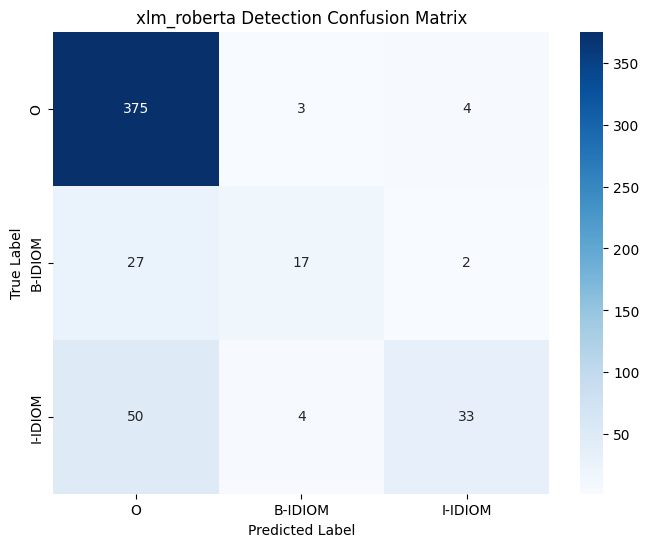


Results for xlm_roberta:
Accuracy: 0.8252
F1 Score: 0.7989
Idiom F1: 0.5714
Idiom Precision: 0.8889
Idiom Recall: 0.4211
ANALYZING DETECTION RESULTS

RESULT SUMMARY — HEBREW_IDIOMS



Overall:
  Accuracy: 0.825 | F1 (weighted): 0.799 | Precision: 0.822 | Recall: 0.825

Idiom Detection (binary ‘any tag > 0’):
  Precision: 0.889 | Recall: 0.421 | F1: 0.571
  TP=56  FP=7  FN=77

 Correct examples (up to 5):
  1. הלוחמים שמו נפשם בכפם בעת הגנתם על מדינת ישראל.
     True: ['O', 'B-IDIOM', 'I-IDIOM', 'I-IDIOM', 'O', 'O', 'O', 'O', 'O']
     Pred: ['O', 'B-IDIOM', 'I-IDIOM', 'I-IDIOM', 'O', 'O', 'O', 'O', 'O']
  2. השופט פקח את עיניו של השר, והוא הבין את טעותו.
     True: ['O', 'B-IDIOM', 'I-IDIOM', 'I-IDIOM', 'O', 'O', 'O', 'O', 'O', 'O']
     Pred: ['O', 'B-IDIOM', 'I-IDIOM', 'I-IDIOM', 'O', 'O', 'O', 'O', 'O', 'O']
  3. בשיחתי עם הגננת על אודות נכדי היא גמרה עליו את ההלל.
     True: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-IDIOM', 'I-IDIOM', 'I-IDIOM', 'I-IDIOM']
     Pred: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-IDIOM', 'I-IDIOM', 'I-IDIOM', 'I-IDIOM']
  4. הבטחתי לצלצל אליך, אך הדבר פרח לי מהזכרון.
     True: ['O', 'O', 'O', 'O', 'O', 'B-IDIOM', 'I-IDIOM', 'I-IDIOM']
  

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train dataset size: 206800
Validation dataset size: 46


/tmp/ipython-input-1553190874.py:211: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Idiom F1,Idiom Precision,Idiom Recall,Confusion Matrix,True Predictions,True Labels
1000,0.080600,1.084623,0.749515,0.660216,0.707920,0.749515,0.124138,0.750000,0.067669,"[[379, 1, 2], [45, 1, 0], [79, 2, 6]]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0]"
2000,0.053200,1.143784,0.755340,0.678236,0.720160,0.755340,0.196078,0.750000,0.112782,"[[377, 2, 3], [42, 3, 1], [76, 2, 9]]","[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2

In [ ]:
CONFIG_NAME = "standard"
for model in ["xlm_roberta", "mt5", "mbert"]:
  for training_mode in ["english_only", "all_languages", "hebrew"]:
    print("="*80)
    print(f"Model: {model}")
    print(f"Training mode: {training_mode}")
    print("="*80 + "\n")

    train_languages = CONDITIONS[training_mode]
    eval_language = "hebrew_idioms"

    trainer, val_dataset = train_detection_model(
      model, train_languages, eval_language, CONFIG_NAME
    )

    detection_trainer, detection_results = eval_detection_model(
      trainer, val_dataset, model
    )

    print("ANALYZING DETECTION RESULTS")
    print("=" * 60)

    original_val_data = validation_datasets[eval_language]

    metrics = detection_report(
        trainer=detection_trainer,
        tokenized_dataset=val_dataset,
        raw_dataset=original_val_data,
        language=eval_language,
        k=5,
    )

    print("\nRecap:",
          f"Acc={metrics['accuracy']:.3f},",
          f"F1w={metrics['f1_weighted']:.3f},",
          f"IdiomF1={metrics['idiom_f1']:.3f},",
          f"TP={metrics['tp']}, FP={metrics['fp']}, FN={metrics['fn']}")

    del trainer
    del val_dataset
    del detection_trainer
    del detection_results
    del metrics